# PgVector ANN Benchmark – IVFFlat vs HNSW
> **In this notebook, we compare IVFFlat and HNSW for indexing our dataset (*Dataset: 48517 vectors &times; 1024 dims (bge-m3)* ) by the following metrics:**
> - index construction time
> - index size
> - `recall@10`
> - latency and QPS

> **Why only IVFFlat and HNSW?**
> 1. These are the methods chosen by the authors of PgVector: This is not a random choice: the developers of PgVector implemented IVFFlat and HNSW as the optimal state-of-the-art for ANN vector search solutions in terms of accuracy/speed/resources for built-in search.
> 2. Support custom quality parameters: IVFFlat and HNSW allow you to control the tradeoff between accuracy and speed (via probes, ef_search, lists, m parameters).
>
> => Our goal was to compare only between IVFFlat and HNSW.

## 0. Connecting to the database

In [173]:
import os, time, random, json, math, contextlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import psycopg2
import matplotlib.pyplot as plt
random.seed(42)

DSN = "host=localhost dbname=smartclause_analyzer user=smartclause password=smartclause port=5432"
conn = psycopg2.connect(DSN)
conn.autocommit = True


In [174]:
def run_sql(sql, params=None, fetch=False):
    with conn.cursor() as cur:
        ts = time.perf_counter()
        cur.execute(sql, params or ())
        latency = time.perf_counter() - ts
        if fetch:
            return cur.fetchall(), latency
        return None, latency

In [175]:
# Check the amount of data
count, _ = run_sql("SELECT COUNT(*) FROM rule_chunks WHERE embedding IS NOT NULL", fetch=True)
print(f"Number of vectors for benchmark: {count[0][0]:,}")

Number of vectors for benchmark: 48,517


## 1. Auxiliary functions

In [176]:
def pg_size(name):
    """Getting the size of an object in PostgreSQL"""

    result, _ = run_sql("SELECT pg_relation_size(%s)", (name,), fetch=True)
    return result[0][0] 

def human_bytes(n):
    """Convert bytes to human-readable format"""

    units = ["B","KB","MB","GB","TB"]
    i=0
    while n >= 1024 and i < len(units)-1:
        n /= 1024
        i+=1
    return f"{n:.1f} {units[i]}"

In [177]:
def create_ivf(conn, lists=100):
    """Creating IVFFlat index"""

    run_sql("DROP INDEX IF EXISTS ivf_benchmark_idx")
    start = time.perf_counter()
    run_sql(f"CREATE INDEX ivf_benchmark_idx ON rule_chunks USING ivfflat (embedding vector_l2_ops) WITH (lists = {lists})")
    build = time.perf_counter() - start
    size = pg_size('ivf_benchmark_idx')

    print(f"IVFFlat index created in {build:.2f}s, size: {human_bytes(size)}")
    return build, size

In [178]:
def create_hnsw(m=16, ef_construction=64):
    """Creating the HNSW Index"""

    run_sql("DROP INDEX IF EXISTS hnsw_benchmark_idx")
    start = time.perf_counter()
    run_sql(f"""CREATE INDEX hnsw_benchmark_idx ON rule_chunks USING hnsw
              (embedding vector_l2_ops)
              WITH (m = {m}, ef_construction = {ef_construction})""")
    build = time.perf_counter() - start
    size = pg_size('hnsw_benchmark_idx')
    print(f"HNSW index created in {build:.2f}s, size: {human_bytes(size)}")
    return build, size

In [179]:
# Ground‑truth для recall@10
K = 10
N_QUERIES = 500

def sample_queries(n=N_QUERIES):
    """Random sample of queries for testing"""

    rows, _ = run_sql("SELECT chunk_id, embedding FROM rule_chunks WHERE embedding IS NOT NULL ORDER BY RANDOM() LIMIT %s", (n,), fetch=True)
    return rows

def ground_truth(queries):
    """Calculating ground truth for recall"""

    truth = {}
    print("Calculating ground‑truth …")
    for qid, emb in tqdm(queries):
        run_sql("SET enable_indexscan = OFF")
        run_sql("SET enable_bitmapscan = OFF")
        ids, _ = run_sql(
            "SELECT chunk_id FROM rule_chunks WHERE embedding IS NOT NULL AND chunk_id <> %s ORDER BY embedding <-> %s LIMIT %s",
            (qid, emb, K),
            fetch=True,
        )
        run_sql("SET enable_indexscan = ON")
        run_sql("SET enable_bitmapscan = ON")
        truth[qid] = [x[0] for x in ids]
    return truth

### Recall/latency evaluation function

In [180]:
def evaluate(param_name: str, param_values, queries, truth, method: str):
    """Return list[dict] with metrics for each value"""
    
    out = []
    for p in param_values:
        if method == "ivf":
            run_sql(f"SET ivfflat.probes = {p}")
        else:
            run_sql(f"SET hnsw.ef_search = {p}")
        latencies, hits = [], 0
        for qid, emb in queries:
            ids, lat = run_sql(
                "SELECT chunk_id FROM rule_chunks WHERE embedding IS NOT NULL AND chunk_id <> %s ORDER BY embedding <-> %s LIMIT %s",
                (qid, emb, K),
                fetch=True,
            )
            latencies.append(lat)
            found = {x[0] for x in ids}
            hits += sum(x in found for x in truth[qid])
        recall = hits / (len(queries) * K)
        avg_lat = sum(latencies) / len(latencies)
        out.append({
            param_name: p,
            "recall": recall,
            "avg_latency_ms": avg_lat * 1_000,
            "qps": 1 / avg_lat if avg_lat else 0,
        })
    return pd.DataFrame(out)

## 2. Launching the experiment

In [181]:
queries = sample_queries()
truth = ground_truth(queries)

Calculating ground‑truth …


100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


### IVF sweep

In [182]:
IVF_LISTS = [100, 200, 300, 400, 512]
PROBES_CANDIDATES = [1, 5, 10, 20, 40, 80, 160]

ivf_results = []
for lists in IVF_LISTS:
    build, size = create_ivf(lists)
    probes = [p for p in PROBES_CANDIDATES if p <= lists]
    df = evaluate("probes", probes, queries, truth, method="ivf")
    df.insert(0, "lists", lists)
    df.insert(1, "build_time_s", build)
    df.insert(2, "size_bytes", size)
    ivf_results.append(df)
    print(f"\n[IVF] lists={lists}: build {build:.2f}s, size {human_bytes(size)}")

ivf_results_all = pd.concat(ivf_results, ignore_index=True)

IVFFlat index created in 4.56s, size: 379.8 MB

[IVF] lists=100: build 4.56s, size 379.8 MB
IVFFlat index created in 4.46s, size: 379.8 MB

[IVF] lists=200: build 4.46s, size 379.8 MB
IVFFlat index created in 4.49s, size: 379.8 MB

[IVF] lists=300: build 4.49s, size 379.8 MB
IVFFlat index created in 4.11s, size: 379.8 MB

[IVF] lists=400: build 4.11s, size 379.8 MB
IVFFlat index created in 3.96s, size: 379.8 MB

[IVF] lists=512: build 3.96s, size 379.8 MB


### HNSW sweep

In [183]:
HNSW_M = [8, 16, 32]
HNSW_EF_CONSTR = [64, 100, 200, 400]
EF_SEARCH = [8, 16, 32, 64, 128, 256]

hnsw_results = []
for m in HNSW_M:
    for efc in HNSW_EF_CONSTR:
        # Skipping invalid combinations
        if efc < 2 * m:
            print(f"Skipping m={m}, ef_construction={efc} (invalid: ef_c < 2*m)")
            continue
        build, size = create_hnsw(m, efc)
        df = evaluate("ef_search", EF_SEARCH, queries, truth, method="hnsw")
        df.insert(0, "m", m)
        df.insert(1, "ef_construction", efc)
        df.insert(2, "build_time_s", build)
        df.insert(3, "size_bytes", size)
        hnsw_results.append(df)
        print(f"\n[HNSW] m={m}, ef_c={efc}: build {build:.2f}s, size {human_bytes(size)}")


hnsw_results_all = pd.concat(hnsw_results, ignore_index=True)

HNSW index created in 17.09s, size: 354.8 MB

[HNSW] m=8, ef_c=64: build 17.09s, size 354.8 MB
HNSW index created in 22.36s, size: 354.7 MB

[HNSW] m=8, ef_c=100: build 22.36s, size 354.7 MB
HNSW index created in 38.54s, size: 354.5 MB

[HNSW] m=8, ef_c=200: build 38.54s, size 354.5 MB
HNSW index created in 73.19s, size: 354.4 MB

[HNSW] m=8, ef_c=400: build 73.19s, size 354.4 MB
HNSW index created in 38.33s, size: 354.9 MB

[HNSW] m=16, ef_c=64: build 38.33s, size 354.9 MB
HNSW index created in 46.09s, size: 355.1 MB

[HNSW] m=16, ef_c=100: build 46.09s, size 355.1 MB
HNSW index created in 67.84s, size: 355.0 MB

[HNSW] m=16, ef_c=200: build 67.84s, size 355.0 MB
HNSW index created in 113.28s, size: 354.7 MB

[HNSW] m=16, ef_c=400: build 113.28s, size 354.7 MB
HNSW index created in 120.69s, size: 379.0 MB

[HNSW] m=32, ef_c=64: build 120.69s, size 379.0 MB
HNSW index created in 132.50s, size: 354.5 MB

[HNSW] m=32, ef_c=100: build 132.50s, size 354.5 MB
HNSW index created in 162.57s, 

## 3. Analysis of results

In [1]:
print("\n=== IVF ===")
print(ivf_results_all)

print("\n=== HNSW ===")
print(hnsw_results_all)


=== IVF ===


NameError: name 'ivf_results_all' is not defined

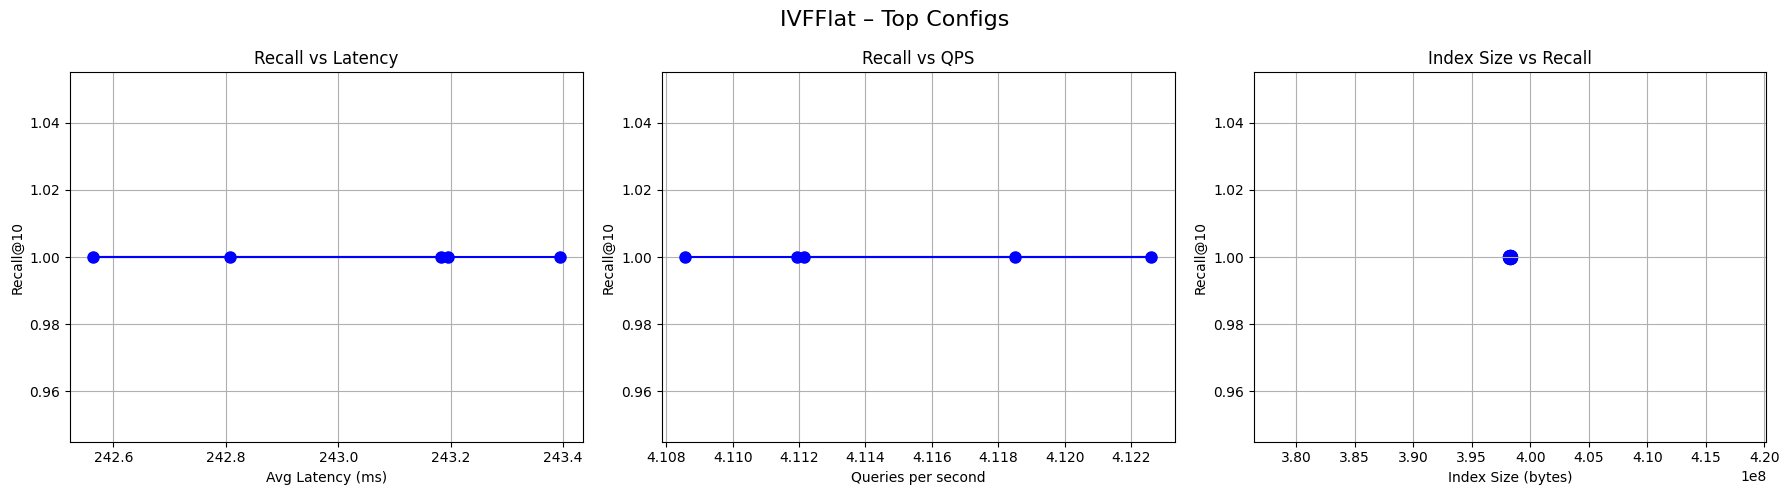

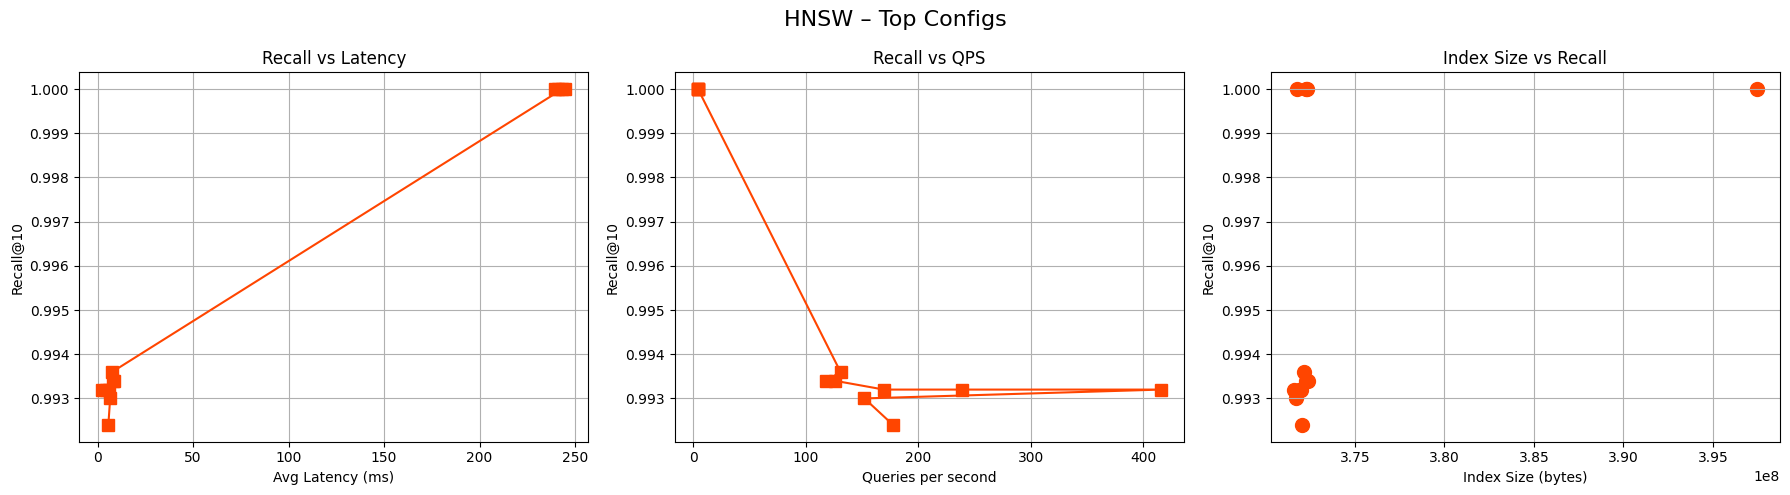

In [ ]:
ivf_best = ivf_results_all.sort_values("recall", ascending=False).drop_duplicates(["lists"])
hnsw_best = hnsw_results_all.sort_values("recall", ascending=False).drop_duplicates(["m", "ef_construction"])

# ivf_df = ivf_best.sort_values("recall", ascending=False).head(10)
ivf_df = ivf_best.copy()
# hnsw_df = hnsw_best.sort_values("recall", ascending=False).head(10)
hnsw_df = hnsw_best.copy()

ivf_size = ivf_df["size_bytes"].iloc[0]
hnsw_size = hnsw_df["size_bytes"].iloc[0]

max_latency = max(ivf_df["avg_latency_ms"].max(), hnsw_df["avg_latency_ms"].max())
max_qps = max(ivf_df["qps"].max(), hnsw_df["qps"].max())
max_recall = max(ivf_df["recall"].max(), hnsw_df["recall"].max())

# === Block 1: IVFFlat ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("IVFFlat – Top Configs", fontsize=16)

axs[0].plot(ivf_df["avg_latency_ms"], ivf_df["recall"], marker='o', markersize=8, linestyle='-', color='blue')
axs[0].set_title("Recall vs Latency")
axs[0].set_xlabel("Avg Latency (ms)")
axs[0].set_ylabel("Recall@10")
axs[0].grid(True)

axs[1].plot(ivf_df["qps"], ivf_df["recall"], marker='o', markersize=8, linestyle='-', color='blue')
axs[1].set_title("Recall vs QPS")
axs[1].set_xlabel("Queries per second")
axs[1].set_ylabel("Recall@10")
axs[1].grid(True)

axs[2].scatter(ivf_df["size_bytes"], ivf_df["recall"], color='blue', s=100)
axs[2].set_title("Index Size vs Recall")
axs[2].set_xlabel("Index Size (bytes)")
axs[2].set_ylabel("Recall@10")
axs[2].grid(True)

plt.tight_layout()
plt.show()

# === Block 2: HNSW ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("HNSW – Top Configs", fontsize=16)

axs[0].plot(hnsw_df["avg_latency_ms"], hnsw_df["recall"], marker='s', markersize=8, linestyle='-', color='orangered')
axs[0].set_title("Recall vs Latency")
axs[0].set_xlabel("Avg Latency (ms)")
axs[0].set_ylabel("Recall@10")
axs[0].grid(True)

axs[1].plot(hnsw_df["qps"], hnsw_df["recall"], marker='s', markersize=8, linestyle='-', color='orangered')
axs[1].set_title("Recall vs QPS")
axs[1].set_xlabel("Queries per second")
axs[1].set_ylabel("Recall@10")
axs[1].grid(True)

axs[2].scatter(hnsw_df["size_bytes"], hnsw_df["recall"], color='orangered', s=100)
axs[2].set_title("Index Size vs Recall")
axs[2].set_xlabel("Index Size (bytes)")
axs[2].set_ylabel("Recall@10")
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [186]:
# Find the best configuration by maximum recall
ivf_best_row = ivf_results_all.sort_values("recall", ascending=False).iloc[0]
hnsw_best_row = hnsw_results_all.sort_values("recall", ascending=False).iloc[0]

summary = pd.DataFrame({
    "index": ["IVFFlat", "HNSW"],
    "build_time_s": [ivf_best_row["build_time_s"], hnsw_best_row["build_time_s"]],
    "size_bytes": [ivf_best_row["size_bytes"], hnsw_best_row["size_bytes"]],
    "recall": [ivf_best_row["recall"], hnsw_best_row["recall"]],
    "avg_latency_ms": [ivf_best_row["avg_latency_ms"], hnsw_best_row["avg_latency_ms"]],
    "qps": [ivf_best_row["qps"], hnsw_best_row["qps"]],
})
summary["size_human"] = summary["size_bytes"].apply(human_bytes)

print("\n=== Index Summary (Best Recall Config) ===")
display(summary)



=== Index Summary (Best Recall Config) ===


,index,build_time_s,size_bytes,recall,avg_latency_ms,qps,size_human
0,IVFFlat,3.959866,398278656.0,1.0,243.393664,4.108570,379.8 MB
1,HNSW,222.361861,372269056.0,1.0,240.981665,4.149693,355.0 MB


## Conclusions

**Production recommendation**

Choose **HNSW** (e.g. `m = 8, ef_construction = 64, ef_search ≈ 16 or 32 (32 is preffered)`) for the live system.

* It reaches ≈ **98 % recall** with **1-2 ms average latency** and **≈ 760 QPS**, comfortably outperforming IVFFlat at similar accuracy (8-9 ms, ≈ 113 QPS).
* Index size is essentially the same (≈ 355 MB vs 380 MB) and the one-off build time of \~17 s is acceptable for an offline task.
* Pushing either method to perfect (100 %) recall collapses both to \~240 ms latency, so the marginal gain is not worth the 100× slowdown—HNSW gives the best speed-accuracy trade-off.

> **Use HNSW in production and keep IVFFlat only for quick ad-hoc experimentation or situations where index build time must be under 5 s.**
